In [1]:
import heeps
import heeps.wavefront.qacits_vlt_package_v4 as qacits
from heeps.util.coord import mas2rms, disk_coord
from heeps.contrast.background import background
from photutils import CircularAperture, aperture_photometry
import numpy as np
import astropy.units as u
from astropy.io import fits
import os
from copy import deepcopy
import matplotlib.pyplot as plt
%matplotlib inline

# Input parameters

mags = [ 6  7  8  9 10 11 12]
dits = [1.e-06 1.e-02 1.e-01]
linear drift = 110 points in each direction


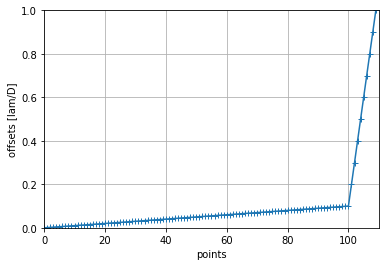

In [2]:
#os.chdir(os.path.normpath(os.path.expandvars('$HOME/CODE/Python/qacits')))
f_lyot_stop = 'ls_%s_%s_%s_%s_%s_%s.fits'
f_phase = 'wavefront/cfull/cube_Cfull_20211007_3600s_300ms_0piston_meters_scao_only_%s_%s.fits'
f_point_err = 'wavefront/point/point_all_3600s_300ms_%s.fits'
cases = ['linear_drift_only', 'scao+linear_drift', 'scao+random_drift', 'scao_only']
targets = ['point', 'alphaCen', 'pi1Gru']
# define range of magnitudes
mag_min = 6
mag_max = 12
mags = np.arange(mag_min, mag_max+1)
print('mags = %s'%mags)
# define DITs (detector integration times)
dits = np.array([1e-6, .01, .1])
print('dits = %s'%dits)
# up to 0.1 lam/D, step = 1/100
# up to 1 lam/D, step = 1/10
xy = np.append(np.arange(100)/1000, np.arange(1,11)/10)
print('linear drift = %s points in each direction'%len(xy))
plt.plot(xy,'-+')
plt.xlim(0, len(xy))
plt.ylim(0, 1)
plt.xlabel('points')
plt.ylabel('offsets [lam/D]')
plt.grid(True), plt.grid(which='minor', linestyle=':');
# dictionary with default qacits parameters
default_params = dict(
    radii = {'inner': (0, 1.7), 'outer': (1.7, 2.3), 'full': (0, 2.7)},
    inner_slope = 1,#0.149,
    outer_slope = 1,#0.063,
    full_coeff = 1,#2,
    ratio = 0,
    phase_tolerance = 60,
    modul_tolerance = 0.33,
    small_tt_regime = 0.3,
    large_tt_regime = 0.2,
)
# qacits: number of averaged frames
n_bin           = 0 # if 0: no averaging, every estimates are returned in a 2D array
                    # if 1: average all frames before computing the estimate
                    # if n_bin=integer < n_img: will return as many estimates (frames are 
                    # averaged by bins of n_img/n_bin before computing the estimates).
force = None #'outer'

In [3]:
rstar_catalog = {'alphaCen': 4.26, # mas
                 'pi1Gru': 9.18, # mas
                 }
def get_fp_offsets(target, diam_ext=36.905, nr=4, disp=True):
    if target in rstar_catalog:
        rstar = rstar_catalog[target]
        fp_offsets_mas = disk_coord(rstar, nr=nr)
        fp_offsets = mas2rms(fp_offsets_mas, diam_ext)
    else:
        fp_offsets = None
    # scatter plot
    if fp_offsets is not None and disp is True:
        print('noffsets = %s'%len(fp_offsets))
        plt.scatter(fp_offsets_mas[:,0], fp_offsets_mas[:,1])
        circ = plt.Circle((0,0), rstar, linestyle=':', color='k', fill=False)
        ax = plt.gca()
        ax.add_artist(circ)
        ax.axis('equal')
        plt.xlabel('x [mas]')
        plt.ylabel('y [mas]')
        plt.title('R = %s mas (%s) - %s pts'%(rstar, target, len(fp_offsets)))
    return fp_offsets

def create_psfs(band, mode, ls_params, case='calib', pupil_shape='', target='', 
        verbose=False):
    # initialize conf
    dir_output = os.path.join('qacits_%s/%s_%s'%(pupil_shape, band, mode), 
            target, case)
    conf = dict(dir_output=dir_output, band=band, mode=mode, nframes=2*len(xy),
            add_phase=True, add_point_err=True)
    if pupil_shape == 'circ':
        conf.update(f_pupil='', spi_width=0, seg_width=0, seg_gap=0)
    else:
        conf.update(f_pupil='pupil/ELT_fullM1.fits')
    conf = heeps.config.read_config(verbose=False, **conf)
    conf = heeps.config.update_config(saveconf=True, verbose=verbose, **conf)
    conf['f_phase'] = os.path.join(conf['dir_input'], 
            f_phase%(band, conf['npupil']))
    conf['f_point_err'] = os.path.join(conf['dir_input'], f_point_err%band)
    conf['f_lyot_stop'] = os.path.join(conf['dir_input'], 'pupil', pupil_shape, 
            f_lyot_stop%(band, mode, *ls_params, conf['npupil']))
    conf['ls_dRext'] = ls_params[0]
    conf['fp_offsets'] = get_fp_offsets(target)
    # load errors
    phase_screens, amp_screens, tiptilts, misaligns \
            = heeps.wavefront.load_errors(verbose=verbose, **conf)
    # linear tiptilt
    diamLS = conf['diam_ext'] - conf['diam_nominal']*conf['ls_dRext']
    lamD = conf['lam']/diamLS*u.rad.to('mas')
    xy_rms = mas2rms(xy*lamD, conf['diam_ext']) # converted to mas, then to rms
    tt = np.array([(x,0) for x in xy_rms] + [(0,y) for y in xy_rms])
    # choose case
    print('\nCase = %s'%case)
    if 'scao_only' in case:
        tiptilts = np.array([None]*conf['nframes'])
    elif 'scao+linear_drift' in case:
        tiptilts = tt
    elif 'scao+random_drift' in case:
        pass
    else: # calib = linear drift only
        tiptilts = tt
        phase_screens = np.array([None]*conf['nframes'])
    # load PSFs
    try:
        psf = fits.getdata(os.path.join(conf['dir_output'], 
            'offaxis_PSF_%s_%s.fits'%(conf['band'], conf['mode'])))
        psfs = fits.getdata(os.path.join(conf['dir_output'], 
            'onaxis_PSF_%s_%s.fits'%(conf['band'], conf['mode'])))
        print('Loading "%s"'%dir_output)
    except FileNotFoundError:
        print('Simulating "%s"'%dir_output)
        # initialize wavefront
        wf = heeps.pupil.pupil(savefits=True, verbose=verbose, **conf)
        # off-axis PSF
        psf = heeps.wavefront.propagate_one(wf, onaxis=False, savefits=True, 
                verbose=verbose, **conf)
        # on-axis PSFs
        psfs = heeps.wavefront.propagate_cube(wf, phase_screens=phase_screens,
                amp_screens=amp_screens, tiptilts=tiptilts, misaligns=misaligns, 
                onaxis=True, savefits=True, verbose=True, **conf)
    # tiptilts in lam/D
    tt_xy = tiptilts*u.rad.to('mas')*4/conf['diam_ext']/lamD
    tt_lamD = np.sqrt(tt_xy[:,0]**2 + tt_xy[:,1]**2)
    return conf, psf, psfs, tt_lamD

def tiptilt_estimate(qacits_params, conf, offaxis_PSF, onaxis_PSF, tt_lamD, 
        model_calibration=False, verbose=True):
    # image sampling given in pixels per lambda/D
    sampling = conf['lam']/conf['diam_ext']/(conf['pscale']*u.mas.to('rad'))
    fwhm = sampling/(1 - conf['ls_dRext'])
    # photutils aperture photometry
    n_off = offaxis_PSF.shape[-1]
    aper = CircularAperture((n_off//2, n_off//2), r=fwhm/2)
    I_off = aperture_photometry(offaxis_PSF, aper)['aperture_sum'].data
    if verbose is True:
        print('photutils aperture photometry: I_off=%s'%np.round(I_off,5))
    # bin + normalize on-axis PSF cube
    onaxis_PSF_binned = qacits.bin_images(onaxis_PSF, n_bin)
    #onaxis_PSF_binned /= I_off
    n_on = onaxis_PSF_binned.shape[-1]
    # tip-tilt estimate
    tiptilt_estimate_full = qacits.quadrant_tiptilt_v8(qacits_params,
            onaxis_PSF_binned, (n_on//2, n_on//2), I_off[0], fwhm,
            calib_tt=tt_lamD, model_calibration=model_calibration, 
            force=force, exact=True, verbose=False)
    tiptilt_estimate = tiptilt_estimate_full[:,0:2]
    # RMS error
    diamLS = conf['diam_ext'] - conf['diam_nominal']*conf['ls_dRext']
    lamD = conf['lam']/diamLS*u.rad.to('mas')
    tt_real = tt_lamD*lamD
    tt_est = np.sqrt(tiptilt_estimate[:,0]**2 + tiptilt_estimate[:,1]**2)*lamD
    rms = np.sqrt(np.mean((tt_real - tt_est)**2))
    return tt_real, tt_est, rms

def plot_calib(qacits_params, conf, psf, psfs, tt_lamD, nframes=None, 
        model_calibration=False):
    tt_real, tt_est, _ = tiptilt_estimate(qacits_params, conf,
        psf, psfs, tt_lamD, model_calibration=model_calibration)
    ts = conf['dit']*np.arange(len(tt_lamD))[:nframes]
    fig, (a0, a1) = plt.subplots(2, 1, figsize=(10,6), sharex=True)
    fig.subplots_adjust(hspace=0)
    a0.plot(ts, tt_real[:nframes], label='error signal', color='k', linestyle='--')
    a0.plot(ts, tt_est[:nframes], label='QACITS estimate')
    a0.set_title('correction at %s band'%conf['band'])
    a0.set_ylabel('Pointing error (mas)')
    a0.legend(loc='upper right'); a0.grid(True)
    a0.set_xlim((0, ts[-1]))
    a0.set_ylim(bottom=0)
    error = tt_real - tt_est
    a1.plot(ts, error[:nframes], label='$\mu = %3.2f mas, \sigma = %3.2f mas$'\
                %(np.mean(error), np.std(error)))
    a1.set_xlabel('Duration (s)')
    a1.set_ylabel('Residuals (mas)')
    a1.legend(loc='upper right'); a1.grid(True)
    a1.set_xlim((0, ts[-1]))

def plot_rms_mag(qacits_params, conf, psf, psfs, tt_lamD, 
        model_calibration=False):
    for conf['dit'] in dits:
        print('DIT = %s s'%conf['dit'])
        for conf['mag'] in mags:
            psf_ON, psf_OFF = background(deepcopy(psfs), deepcopy(psf), **conf)
            _, _, rms = tiptilt_estimate(qacits_params, conf, psf_OFF, psf_ON, 
                    tt_lamD, model_calibration=model_calibration, verbose=False)
            print('   mag = %s, RMS = %s mas'%(conf['mag'], np.round(rms,3)))

## Circular pupil


Case = calib
Loading "qacits_circ/L_CVC/calib"
photutils aperture photometry: I_off=[0.30839]

Model calibration results:
Inner slope = 0.386
Outer slope = 0.176
Full coeff  = 4.074


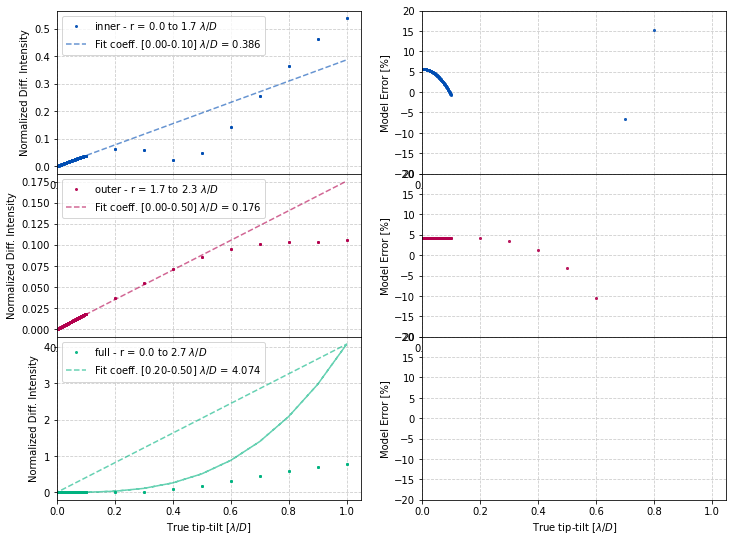

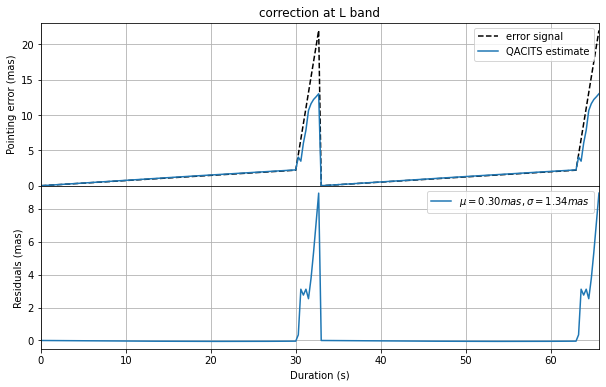

In [4]:
conf, psf, psfs, tt_lamD = create_psfs('L', 'CVC', [0.0291, 0.08, 0.0317], pupil_shape='circ')
circ_params = deepcopy(default_params)
plot_calib(circ_params, conf, psf, psfs, tt_lamD, model_calibration=True)

photutils aperture photometry: I_off=[0.30839]


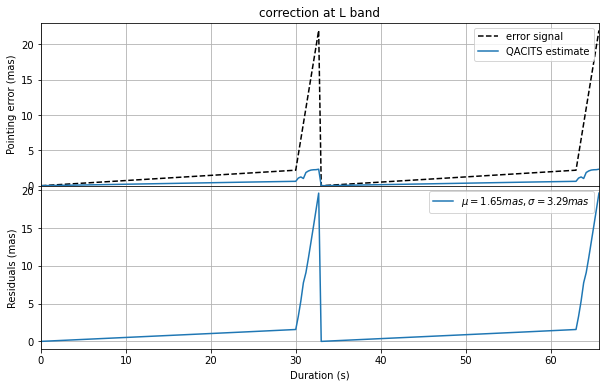

In [5]:
plot_calib(default_params, conf, psf, psfs, tt_lamD)

## Full M1 pupil


Case = calib
Loading "qacits_/L_CVC/calib"
photutils aperture photometry: I_off=[0.22572]

Model calibration results:
Inner slope = 0.225
Outer slope = 0.123
Full coeff  = 2.288


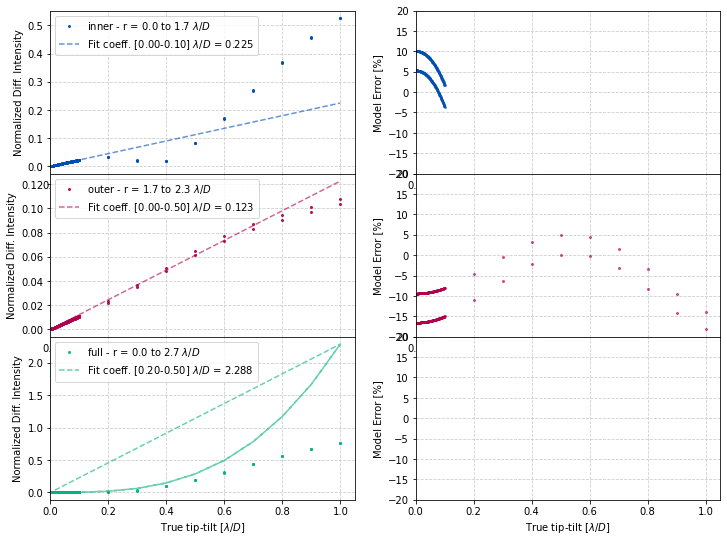

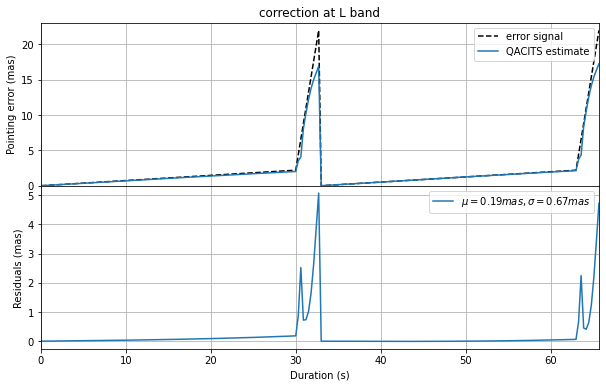

In [6]:
conf, psf, psfs, tt_lamD = create_psfs('L', 'CVC', [0.0291, 0.08, 0.0317])
fullM1_params = deepcopy(default_params)
plot_calib(fullM1_params, conf, psf, psfs, tt_lamD, model_calibration=True)


Case = scao+random_drift
Loading "qacits_/L_CVC/scao+random_drift"
photutils aperture photometry: I_off=[0.22407]


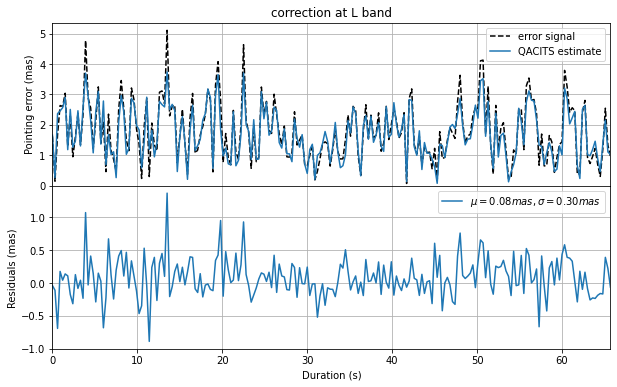

In [7]:
conf, psf, psfs, tt_lamD = create_psfs('L', 'CVC', [0.0291, 0.08, 0.0317], 'scao+random_drift')
plot_calib(fullM1_params, conf, psf, psfs, tt_lamD)

In [8]:
plot_rms_mag(fullM1_params, conf, psf, psfs, tt_lamD)

DIT = 1e-06 s
   mag = 6, RMS = 5.027 mas
   mag = 7, RMS = 7.746 mas
   mag = 8, RMS = 11.171 mas
   mag = 9, RMS = 15.743 mas
   mag = 10, RMS = 19.234 mas
   mag = 11, RMS = 20.084 mas
   mag = 12, RMS = 20.211 mas
DIT = 0.01 s
   mag = 6, RMS = 0.308 mas
   mag = 7, RMS = 0.316 mas
   mag = 8, RMS = 0.378 mas
   mag = 9, RMS = 0.698 mas
   mag = 10, RMS = 1.955 mas
   mag = 11, RMS = 4.703 mas
   mag = 12, RMS = 7.582 mas
DIT = 0.1 s
   mag = 6, RMS = 0.308 mas
   mag = 7, RMS = 0.308 mas
   mag = 8, RMS = 0.312 mas
   mag = 9, RMS = 0.351 mas
   mag = 10, RMS = 0.588 mas
   mag = 11, RMS = 1.525 mas
   mag = 12, RMS = 4.005 mas
